In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Vectorized metropolis algorithm in 1D

Different types of boundary conditions to consider:
1. Periodic: ends of the lattice are connected and interact with each other.
2. Open: ends of the lattice do not interact with each other (these spins only have 1 neighbor).
3. Fixed: spin at one end of the lattice is fixed. (https://staff.fysik.su.se/~ardonne/files/theses/bachelor-thesis_christopher-litens.pdf)
4. Padded: ends padded with all up/down spins.

In [ ]:

class VectorizedMetropolis1D:
    def __init__(self, beta, J, H):
        """
        Args:
            beta: 1/(k_B * T)
            J: strength of nearest neighbor interactions
            H: strength of external magnetic field
        """
        self.beta = beta
        self.J = J
        self.H = H
    
    def nn_alignment(self, X_lattice):
        """ 
        Args:
            X_lattice (ndarray): current state of system

        Returns:
            X_neighbors (ndarray): nearest neighbor contributions to the
            interaction energy
        """
        # Sum nearest neighbor contributions to energy by shifting X_lattice.
        # Open boundary conditions (ends of lattice do not interact with each other).
        X_neighbors = np.zeros_like(X_lattice)      # Initiate array with all 0's.
        X_neighbors[:-1] += X_lattice[1:]           # Left neighbor contribution
        X_neighbors[1:]  += X_lattice[:-1]          # Right neighbor contribution

        # For periodic boundary conditions, add these lines.
        # X_neighbors[-1] += X_lattice[0]
        # X_neighbors[0] += X_lattice[-1]

        return X_neighbors

    
    def update_spins(self, X_lattice):
        """ 
        Args:
            X_lattice (ndarray): current state of system
        
        Returns:
            X_result (ndarray): updated state of system
        """
        # Calculate change in energy required to flip each spin.
        X_neighbors = self.nn_alignment(X_lattice)
        X_Ei = - self.J * X_lattice * X_neighbors - self.H * X_lattice
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = X_lattice.copy()         # Updated matrix
        # If energy < 0 (spin is currently down), flip up.
        X_result[X_deltaE < 0] = 1

        # If energy > 0 (spin is currently up), flip down with probability
        # given by Boltzmann factor.
        X_result[(X_deltaE > 0) & (X_deltaE < np.exp(- self.beta * X_deltaE))] = -1

        return X_result


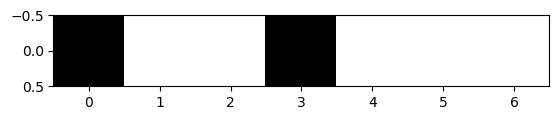

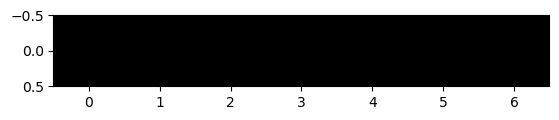

0 iterations


In [71]:
np.random.seed(0)
lattice = np.random.choice([-1, 1], size=7)
# lattice = lattice.reshape(1, -1)

Ising = VectorizedMetropolis1D(beta=10, J=1, H=0.1)
# print("Initial lattice and neighbors")
# print(lattice)
# print(Ising.neighbor_coupling(lattice))
# print()

# for i in range(10):
#     lattice = Ising.update_spins(lattice)
#     # print(f"Update {i}")
#     print(lattice)
#     # print(Ising.neighbor_coupling(lattice))
#     # print()

array = lattice.reshape(1, -1)
fig = plt.figure()
plt.imshow(array, cmap='gray')
plt.pause(0.001)

for i in range(50):
    lattice = Ising.update_spins(lattice)
    array = lattice.reshape(1, -1)
    plt.imshow(array, cmap='gray')
    plt.pause(0.001)
    # print(lattice)
    if np.all(lattice == 1):
        break
plt.show()
print(f"{i} iterations")


Initial state
[[-1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1  1 -1
  -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1  1  1  1  1
  -1  1]]
iterations: 49


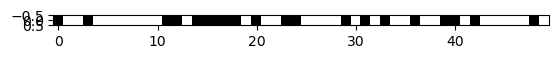

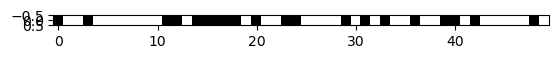

In [ ]:
np.random.seed(0)
frames = []
size = 50
lattice = np.random.choice([-1, 1], size=size)
array = lattice.reshape(1, -1)
frames.append(array)

print("Initial state")
print(array)
plt.imshow(array, cmap="gray")

Ising = VectorizedMetropolis1D(beta=0.1, J=5, H=0.1)
fig = plt.figure()
img = plt.imshow(array, cmap="gray")

for i in range(50):
    lattice = Ising.update_spins(lattice)
    array = lattice.reshape(1, -1)
    frames.append(array)
    if np.all(lattice == 1):
        break

print("iterations:", i)
# print("Final state")
# plt.figure()
# plt.imshow(array, cmap="gray")      # Change so that final state color is consistent with all up.


def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

# Metropolis in 2D

In [ ]:
class VectorizedMetropolis2D:
    def __init__(self, T, J=1.0, H=0.0):
        """
        Args:
            T (float): temperature
            J (float): strength of nearest neighbor interactions
            H (float): strength of external magnetic field
        """
        self.beta = 1 / T   # Set Boltzmann constant to 1.
        self.J = J
        self.H = H
    
    def nn_alignment(self, X_lattice):
        """ 
        Sum the spin values of the 4 nearest neighbors (nn) for each spin in
        the lattice. This represents the net alignment of the nn spins. 
        Here we use periodic boundary conditions.
        Args:
            X_lattice (2darray): current state of the spin system

        Returns:
            X_nn (2darray): sum of nn spin values
        """
        X_nn = np.zeros_like(X_lattice)
        X_nn[:, :-1] += X_lattice[:, 1:]    # Left nn contribution
        X_nn[:, 1:] += X_lattice[:, :-1]    # Right nn contribution
        X_nn[:-1, :] += X_lattice[1:, :]    # Lower nn contribution
        X_nn[1:, :] += X_lattice[:-1, :]    # Upper nn contribution

        # Periodic boundary conditions
        X_nn[:, 0] += X_lattice[:, -1]      # Right-end to left-end
        X_nn[:, -1] += X_lattice[:, 0]      # Left-end to right-end
        X_nn[0, :] += X_lattice[-1, :]      # Bottom-end to top-end
        X_nn[-1, :] += X_lattice[-1, :]     # Top-end to bottom-end

        return X_nn
    
    def update_spins(self, X_lattice):
        """ 
        Update spins in the lattice using metropolis algorithm.
        Args:
            X_lattice (2darray): current state of the spin system
        
        Returns:
            S_result (2darray): updated state of the spin system
        """
        # Calculate change in energy required to flip each spin.
        X_nn = self.nn_alignment(X_lattice)
        X_Ei = -self.J * X_lattice * X_nn - self.H * X_lattice
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = X_lattice.copy()
        # If deltaE < 0 (spin is currently down), flip up.
        X_result[X_deltaE < 0] = 1

        # If deltaE > 0 (spin is currently up), flip down with probability
        # given by Boltzmann factor.
        X_result[(X_deltaE > 0) & (X_deltaE < np.exp(- self.beta * X_deltaE))] = -1

        return X_result



iterations: 5


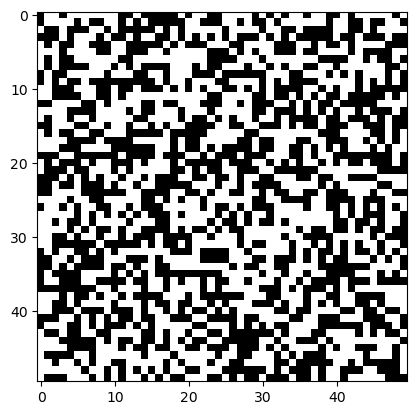

In [26]:
np.random.seed(0)
frames = []
size = (50, 50)
lattice2d = np.random.choice([-1, 1], size=size)
frames.append(lattice2d)

Ising2d = VectorizedMetropolis2D(T=0.1, J=1, H=0.1)
fig = plt.figure()
img = plt.imshow(lattice2d, cmap="gray")

for i in range(50):
    lattice2d = Ising2d.update_spins(lattice2d)
    frames.append(lattice2d)
    if np.all(lattice2d == 1):
        break
print("iterations:", i + 1)

def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

## Nonvectorized metropolis in 1D

In [57]:

# 1d Ising using Metropolis (non-vectorized).

class SimpleMetropolis1D():

    def __init__(self, beta, J, H):
        self.beta = beta
        self.J = J
        self.H = H

    def energy(self, lattice, i):
        current = lattice[i]

        # Periodic/circular boundary conditions.
        # if i == len(self.lattice) - 1:
        #     j1 = i - 1
        #     j2 = 0
        # elif i == 0:
        #     j1 = len(self.lattice) - 1
        #     j2 = i + 1
        # else:
        #     j1, j2 = i - 1, i + 1
        # neighbor1, neighbor2 = self.lattice[j1], self.lattice[j2]

        # Open boundary conditions
        if i == len(lattice) - 1:
            neighbor1 = lattice[i - 1]
            neighbor2 = None
        elif i == 0:
            neighbor1 = None
            neighbor2 = lattice[i + 1]
        else:
            neighbor1 = lattice[i - 1]
            neighbor2 = lattice[i + 1]
        
        m = 0
        for n in [neighbor1, neighbor2]:
            if n == 1:      # spin up
                m += 1
            else:           # spin down
                m -= 1
        
        E_up = -self.J * m - self.H
        E_down = self.J * m + self.H
        delta_E = E_down - E_up     # > 0

        if current == 1:
            return delta_E
        else:
            return -delta_E
        

    def update_spins(self, lattice):
        i = np.random.randint(len(lattice))
        delta_E = self.energy(lattice, i)
        # print(i)

        if delta_E < 0:     # current is down, so flip it up.
            lattice[i] = 1
            return lattice

        # current is up, so flip it down with some probability.
        prob_down = np.exp(-self.beta * delta_E)
        p = np.random.rand()
        if p < prob_down:
            lattice[i] = -1
        
        return lattice
        

[[-1  1  1 -1  1  1  1  1  1  1]]
Initial state
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1 -1  1 -1  1  1  1  1  1  1]]
[[-1 -1  1 -1  1  1  1  1  1  1]]
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1  1  1 -1  1  1  1  1  1  1]]
[[-1  1  1  1  1  1  1  1  1  1]]
[[1 1 1 1 1 1 1 1 1 1]]
iterations: 9
Final state


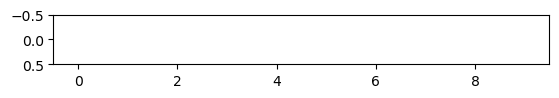

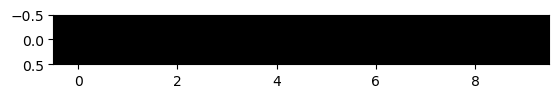

In [59]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames = []
np.random.seed(0)
size = 10
lattice = np.random.choice([-1, 1], size=size)
array = lattice.reshape(1, -1)
frames.append(array)
print(array)

print("Initial state")
simple_Ising = SimpleMetropolis1D(beta=1, J=1, H=0.1)
fig = plt.figure()
img = plt.imshow(array, cmap="gray")

for i in range(1000):
    lattice = simple_Ising.update_spins(lattice)
    array = lattice.reshape(1, -1)
    print(array)
    frames.append(array)
    if np.all(lattice == 1):
        break

print("iterations:", i)
print("Final state")
plt.figure()
plt.imshow(array, cmap="gray")      # Change so that final state color is consistent with all up.

def simple_animate(frame):
    img.set_array(frame)

simple_animation = FuncAnimation(fig, simple_animate, frames=frames, interval=len(frames))
HTML(simple_animation.to_jshtml())

In [98]:
np.random.seed(0)
lattice = np.random.choice([-1, 1], size=5)
print(lattice)

Ising = SimpleMetropolis1D(beta=1, J=1, E_B=0.1, lattice=lattice)

# for i in range(10):
#     print(Ising.update())

i = 0
while True:
    lattice = Ising.update()
    print(lattice)
    i += 1
    if np.all(lattice == 1):
        break
print(f"{i} iterations")

[-1  1  1 -1  1]
[-1  1  1  1  1]
[-1  1  1  1  1]
[-1  1  1  1  1]
[-1  1  1  1 -1]
[ 1  1  1  1 -1]
[-1  1  1  1 -1]
[-1 -1  1  1 -1]
[-1 -1  1  1 -1]
[-1  1  1  1 -1]
[ 1  1  1  1 -1]
[ 1  1  1  1 -1]
[ 1  1  1  1 -1]
[ 1  1  1  1 -1]
[-1  1  1  1 -1]
[-1  1  1 -1 -1]
[ 1  1  1 -1 -1]
[ 1  1  1 -1 -1]
[-1  1  1 -1 -1]
[-1  1  1 -1 -1]
[-1  1  1  1 -1]
[-1  1  1  1 -1]
[-1  1  1  1 -1]
[-1  1  1  1  1]
[1 1 1 1 1]
24 iterations


## Non-vectorized heat bath in 1D

In [ ]:
""" 
(pseudocode)
1d Ising using heat bath (non-vectorized).

lattice = np.random.randint(2, size=n) 

# Energy of spin at position i.
def energy(self, i):
    current = self.lattice[i]
    neighbor1, neighbor2 = self.lattice[i-1], self.lattice[i+1]
    for n in [neighbor1, neighbor2]:
        if n == up:
            m += 1
        else:
            m -= 1

    E_up = -J * m - E_B
    E_down = J * m + E_B
    return (E_up, E_down)


def update(self):
    i = np.random.randint(len(self.lattice))
    E_up, E_down = self.energy(i)
    prob_up = exp(-self.beta * E_up) / (exp(-self.beta * E_up) + exp(-self.beta * E_down))
    p = np.random.rand()

    if p < prob_up:
        self.lattice[i] = up
    else:
        self.lattice[i] = down

"""